In [1]:
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os

In [2]:
def extract_features(file_path, max_pad_len=174):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    mfccs = np.pad(mfccs, ((0, 0), (0, max_pad_len - mfccs.shape[1])), 'constant')


    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)
    spectrogram = tf.signal.stft(audio_tensor, frame_length=1024, frame_step=512, fft_length=1024)
    spectrogram = tf.abs(spectrogram)


    spectrogram = tf.expand_dims(spectrogram, axis=-1)  # Add a channel dimension
    spectrogram = tf.image.resize(spectrogram, [mfccs.shape[0], max_pad_len])

    return mfccs, spectrogram

In [3]:
def load_data(dataset_path):
    mfccs_list = []
    spectrogram_list = []
    labels = []
    
    for fold in os.listdir(dataset_path):
        fold_path = os.path.join(dataset_path, fold)
        if os.path.isdir(fold_path):
            for file_name in os.listdir(fold_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(fold_path, file_name)
                    mfccs, spectrogram = extract_features(file_path)
                    label = int(file_name.split('-')[1])
                    mfccs_list.append(mfccs)
                    spectrogram_list.append(spectrogram)
                    labels.append(label)
    
    return np.array(mfccs_list), np.array(spectrogram_list), np.array(labels)

In [4]:
dataset_path = 'UrbanSound8K'
mfccs, spectrograms, labels = load_data(dataset_path)
X_mfcc_train, X_mfcc_test, X_spec_train, X_spec_test, y_train, y_test = train_test_split(
    mfccs, spectrograms, labels, test_size=0.2, random_state=42)

/Users/sivaprasanth/.pyenv/versions/3.10.12/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/Users/sivaprasanth/.pyenv/versions/3.10.12/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/Users/sivaprasanth/.pyenv/versions/3.10.12/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [5]:
input_shape_mfcc = X_mfcc_train[0].shape
model_mfcc = models.Sequential([
    layers.Input(shape=input_shape_mfcc),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])
model_mfcc.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [6]:
history_mfcc = model_mfcc.fit(X_mfcc_train, y_train, epochs=10, validation_data=(X_mfcc_test, y_test))

Epoch 1/10
219/219 [==============================] - 1s 3ms/step - loss: 6.4367 - accuracy: 0.1698 - val_loss: 2.0951 - val_accuracy: 0.2381
Epoch 2/10
219/219 [==============================] - 0s 2ms/step - loss: 2.1443 - accuracy: 0.2286 - val_loss: 1.9708 - val_accuracy: 0.2868
Epoch 3/10
219/219 [==============================] - 0s 2ms/step - loss: 2.0274 - accuracy: 0.2604 - val_loss: 1.9264 - val_accuracy: 0.3005
Epoch 4/10
219/219 [==============================] - 1s 2ms/step - loss: 1.9179 - accuracy: 0.2955 - val_loss: 1.8740 - val_accuracy: 0.2942
Epoch 5/10
219/219 [==============================] - 0s 2ms/step - loss: 1.8502 - accuracy: 0.3125 - val_loss: 1.7677 - val_accuracy: 0.3515
Epoch 6/10
219/219 [==============================] - 0s 2ms/step - loss: 1.7738 - accuracy: 0.3394 - val_loss: 1.7193 - val_accuracy: 0.3703
Epoch 7/10
219/219 [==============================] - 0s 2ms/step - loss: 1.7343 - accuracy: 0.3568 - val_loss: 1.6820 - val_accuracy: 0.3578
Epoch 

In [7]:
input_shape_spec = X_spec_train[0].shape
model_spec = models.Sequential([
    layers.Input(shape=input_shape_spec),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])
model_spec.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
history_spec = model_spec.fit(X_spec_train, y_train, epochs=10, validation_data=(X_spec_test, y_test))

Epoch 1/10
219/219 [==============================] - 5s 21ms/step - loss: 1.6478 - accuracy: 0.4210 - val_loss: 1.2869 - val_accuracy: 0.5633
Epoch 2/10
219/219 [==============================] - 5s 21ms/step - loss: 1.2539 - accuracy: 0.5689 - val_loss: 1.1261 - val_accuracy: 0.6394
Epoch 3/10
219/219 [==============================] - 4s 20ms/step - loss: 1.0634 - accuracy: 0.6322 - val_loss: 0.9917 - val_accuracy: 0.7104
Epoch 4/10
219/219 [==============================] - 4s 20ms/step - loss: 0.9738 - accuracy: 0.6707 - val_loss: 0.9015 - val_accuracy: 0.7304
Epoch 5/10
219/219 [==============================] - 5s 21ms/step - loss: 0.8618 - accuracy: 0.7055 - val_loss: 0.8404 - val_accuracy: 0.7596
Epoch 6/10
219/219 [==============================] - 5s 21ms/step - loss: 0.7843 - accuracy: 0.7343 - val_loss: 0.7712 - val_accuracy: 0.7665
Epoch 7/10
219/219 [==============================] - 5s 21ms/step - loss: 0.7095 - accuracy: 0.7595 - val_loss: 0.7452 - val_accuracy: 0.7859

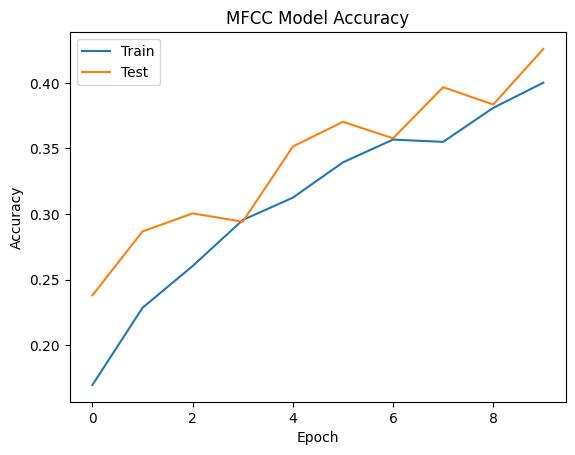

In [9]:
plt.plot(history_mfcc.history['accuracy'])
plt.plot(history_mfcc.history['val_accuracy'])
plt.title('MFCC Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

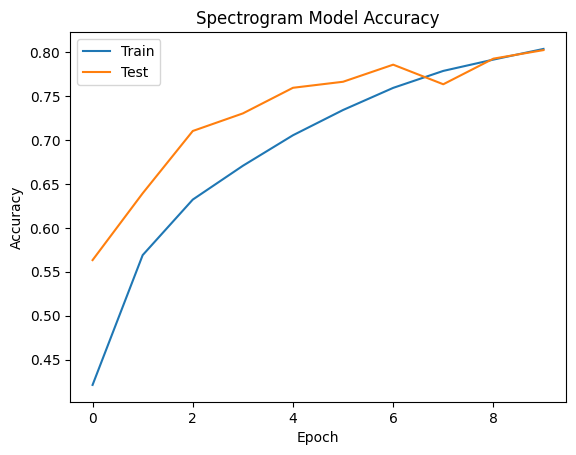

In [10]:
plt.plot(history_spec.history['accuracy'])
plt.plot(history_spec.history['val_accuracy'])
plt.title('Spectrogram Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
